## Overlapping RNAP and repressor binding site

Required packages:

In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

fdir = '../data/'
out_fdir = '../plots/fig14/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb`, we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
og_promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
og_rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
og_rep_site = 'AATTGTGAGCGGATAACAATT'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, og_rnap_site)

Similarly, we read in the experimentally determined energy matrix for the lacI repressor (Barnes et al., 2019) and normalize the energy matrix.

In [5]:
O1_1027_raw = np.load(fdir + 'energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], og_rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Engineering promoter sequence with overlapping binding sites

In [6]:
def generate_promoter_sequence(l_promoter, rnap_start, rep_start, l_rnap, l_rep, rnap_emat, rep_emat):
	"""
    Generates a promoter sequence with overlapping RNAP and repressor binding sites.

    Args:
        l_promoter (int): Length of the promoter sequence.
        rnap_start (int): Starting position of the RNAP binding site.
        rep_start (int): Starting position of the repressor binding site.
        l_rnap (int): Length of the RNAP binding site.
        l_rep (int): Length of the repressor binding site.
        rnap_emat (np.array): Energy matrix for RNAP.
        rep_emat (np.array): Energy matrix for the repressor.

    Returns:
        tuple: A tuple containing:
            - str: Full promoter sequence as a string.
            - str: RNAP binding site sequence within the promoter.
            - str: Repressor binding site sequence within the promoter.
    """
	# Initialize the promoter seq with random bases
	bases = ['A', 'C', 'G', 'T']
	promoter_seqs = np.random.choice(bases, l_promoter)

	# Function to get the base with the lowest energy for a given position
	def get_lowest_energy_base(emat, pos):
		energies = emat[pos]
		return bases[np.argmin(energies)]

	# Function to calculate the lowest energy base when sites overlap
	def get_lowest_energy_base_overlap(rnap_emat, rep_emat, pos_rnap, pos_rep):
		energies = rnap_emat[pos_rnap] + rep_emat[pos_rep]
		return bases[np.argmin(energies)]

	# Generate the promoter seq
	for i in range(l_rnap):
		rnap_pos = rnap_start + i

		if rnap_pos < l_promoter:
			promoter_seqs[rnap_pos] = get_lowest_energy_base(rnap_emat, i)

	for i in range(l_rep):
		rep_pos = rep_start + i

		if rep_pos < l_promoter:
			if rep_pos >= rnap_start and rep_pos < rnap_start + l_rnap:
				overlap_index = rep_pos - rnap_start
				promoter_seqs[rep_pos] = get_lowest_energy_base_overlap(rnap_emat, rep_emat, overlap_index, i)
			else:
				promoter_seqs[rep_pos] = get_lowest_energy_base(rep_emat, i)

	rnap_sites = "".join(promoter_seqs[rnap_start:rnap_start + l_rnap])
	rep_sites = "".join(promoter_seqs[rep_start:rep_start + l_rep])

	return "".join(promoter_seqs), rnap_sites, rep_sites

def generate_all_promoter_sequences(l_promoter, rnap_start, rep_start_initial, l_rnap, l_rep, rnap_emat, rep_emat, step_size=5):
	"""
    Generates multiple promoter sequences with overlapping binding sites
	by varying the start position of the repressor binding site.

    Args:
        l_promoter (int): Length of the promoter sequence.
        rnap_start (int): Starting position of the RNAP binding site.
        rep_start_initial (int): Initial starting position of the repressor binding site.
        l_rnap (int): Length of the RNAP binding site.
        l_rep (int): Length of the repressor binding site.
        rnap_emat (np.array): Energy matrix for RNAP.
        rep_emat (np.array): Energy matrix for the repressor.
        step_size (int, optional): Step size for shifting the repressor binding site. Defaults to 5.

    Returns:
        list: A list of tuples, each containing:
            - int: Start position of the repressor binding site.
            - int: End position of the repressor binding site.
            - str: Full promoter sequence as a string.
            - str: RNAP binding site sequence within the promoter.
            - str: Repressor binding site sequence within the promoter.
    """
	res = []

	for rep_start in range(rep_start_initial, rnap_start - l_rep + 1, -step_size):
		promoter, rnap_site, rep_site = generate_promoter_sequence(l_promoter, rnap_start, rep_start, l_rnap, l_rep, rnap_emat, rep_emat)
		rep_end = rep_start + l_rep - 1
		res.append((rep_start, rep_end, promoter, rnap_site, rep_site))

	return res

In [7]:
# Provided inputs
l_promoter = 160
rnap_start = og_promoter.find(og_rnap_site)
rep_start_initial = og_promoter.find(og_rep_site)
l_rnap = len(og_rnap_site)
l_rep = len(og_rep_site) - 5
step_size = 3

# Run the function with the provided inputs
res = generate_all_promoter_sequences(l_promoter, rnap_start, rep_start_initial, l_rnap, l_rep, rnap_emat, rep_emat,
										step_size=step_size)

### 1.2 Plotting information footprints and expression shift matrices for promoter sequences with varying degree of overlapping binding sites

To plot the series of information footprints with varying degree of overlap between the RNAP binding site and the repressor binding site, we use the following customized `plot_footprint` function that has some small differences from the function that we use in the rest of the notebooks to plot information footprints.

In [8]:
def plot_footprint(promoter, df, region_params,
				   nbins=2, up_scaling_factor=1,
				   x_lims=None, fig_width=10, fig_height=2.9,
				   max_signal=None,
				   outfile=None,
				   return_fp=False,
				   smoothed=True, windowsize=3,
				   noxticks=False,
				   overlap=None):
	"""
    Plots the information footprint of a promoter region.

    Args:
        promoter (str): Sequence of the promoter.
        df (pandas.DataFrame): DataFrame with mutant sequences and their corresponding expression levels.
        region_params (list of tuples): List of parameters for binding regions.
        nbins (int, optional): Number of bins for calculating mutual information. Defaults to 2.
        up_scaling_factor (float, optional): Scaling factor to calculate the boundary between the two bins. Defaults to 1.
        x_lims (tuple, optional): Limits for the x-axis. Defaults to None.
        fig_width (float, optional): Width of the figure. Defaults to 10.
        fig_height (float, optional): Height of the figure. Defaults to 2.9.
        max_signal (float, optional): Maximum y-axis value. Defaults to None.
        outfile (str, optional): File path to save the plot. Defaults to None.
        return_fp (bool, optional): If True, returns the calculated footprint data. Defaults to False.
        smoothed (bool, optional): Whether to apply smoothing to the footprint. Defaults to True.
        windowsize (int, optional): Window size for smoothing. Defaults to 3.
        noxticks (bool, optional): If True, removes x-axis ticks. Defaults to False.
        overlap (int, optional): Overlap in base pairs to display in the plot text. Defaults to None.

    Returns:
        np.array or None: The calculated footprint data if `return_fp` is True, otherwise None.
    """
	
	mut_list = df['seq'].values
	mu_data = df['norm_ct_1']
	upper_bound = up_scaling_factor * np.mean(mu_data)

	footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
											   pseudocount=10**(-6),
											   smoothed=smoothed, windowsize=windowsize)
	exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter)
	
	fig, ax = plt.subplots(figsize=(fig_width, fig_height))

	if x_lims is not None:
		ax.set_xlim(x_lims[0], x_lims[1])
	else:
		ax.set_xlim(-115, 45)

	if max_signal is None:
		max_signal = max(footprint)
	
	ax.set_ylim(top=max_signal*1.15)
	for region in region_params:
		if len(region)==4:
			tregs.footprint.label_binding_site(ax, region[0], region[1], max_signal, region[2], region[3])
		else:
			tregs.footprint.label_binding_site(ax, region[0], region[1], max_signal, region[2], region[3],
						   lifted=region[4])

	if smoothed:
		cut = int((windowsize - 1) / 2)
		x = np.arange(-115 + cut, 45 - cut)
	else:
		x = np.arange(-115, 45)
	shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
	ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)

	if noxticks:
		ax.set_xticks([])
	else:
		ax.tick_params(axis='x', labelsize=14)
	ax.tick_params(axis='y', labelsize=14)

	plt.text(0.025, 0.9, f'Overlap:\n{overlap} bp', transform=plt.gca().transAxes, fontsize=12,
		 	 verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

	plt.tight_layout()
	if outfile is not None:
		plt.savefig(outfile, dpi=300, bbox_inches='tight')
	plt.show()

	if return_fp:
		return footprint

We also write the function below to calculate the degree of overlap between the two binding sites.

In [9]:
def calculate_overlap(rnap_start, rnap_end, rep_start, rep_end):
	"""
    Calculates the degree of overlap (in base pairs) between two binding sites.

    Args:
        rnap_start (int): Start position of the RNAP binding site.
        rnap_end (int): End position of the RNAP binding site.
        rep_start (int): Start position of the repressor binding site.
        rep_end (int): End position of the repressor binding site.

    Returns:
        int: The overlap length in base pairs. Returns 0 if there is no overlap.
    """
	overlap_start = max(rnap_start, rep_start)
	overlap_end = min(rnap_end, rep_end)
	if overlap_start < overlap_end:
		overlap_length = overlap_end - overlap_start + 1
		return overlap_length
	return 0

The series of information footprints are plotted below, where the repressor binding site is slided from the right of the -10 binding site to between the -10 and -35 binding sites.

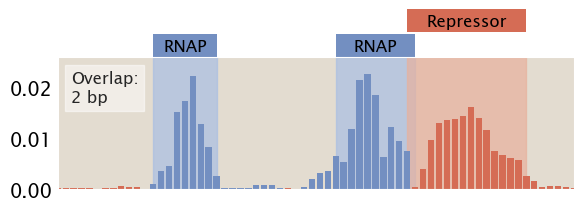

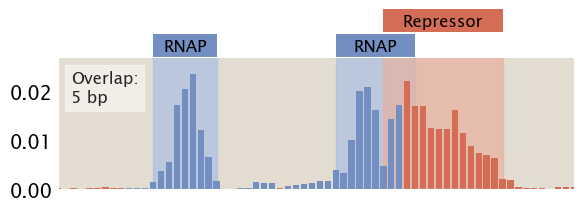

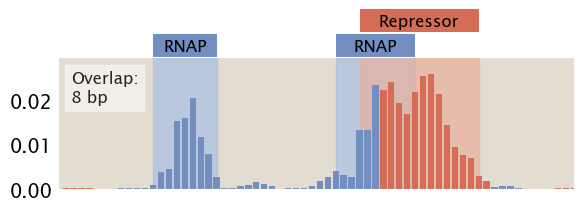

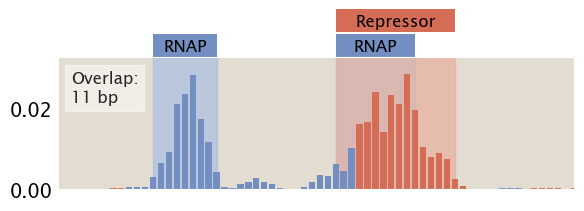

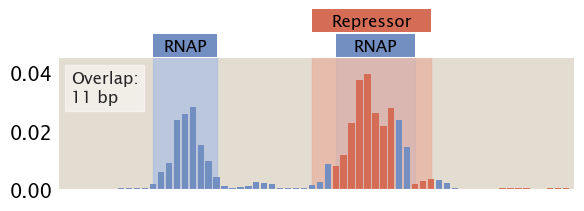

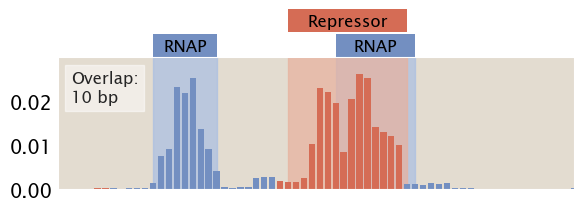

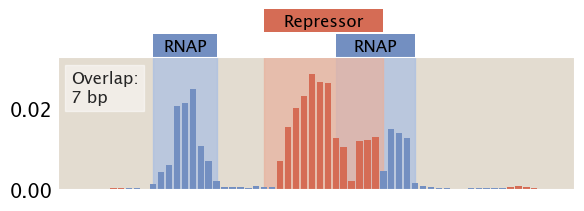

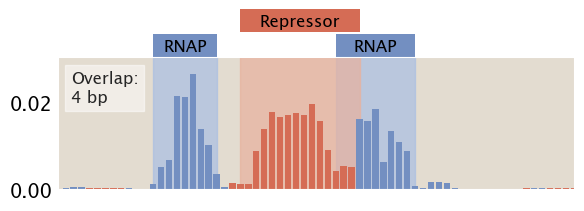

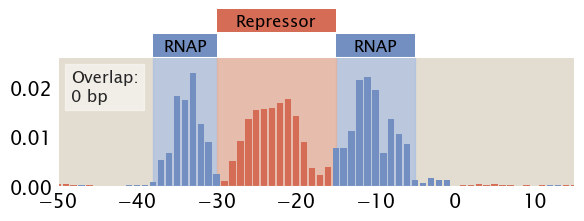

In [10]:
# Print the resulting promoter sequences
i = 0
for rep_start, rep_end, promoter, rnap_site, rep_site in res[2:11]:
	n_NS = len(genome)
	n_p = 4600
	n_r = 10
	ep_wt = -5
	er_wt = -15

	df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
							*[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

	overlap = True #False if i == 0 else True #or i == len(res) - 2
	noxticks = False if i == len(res[2:11]) - 1 else True
	fig_height = 2.5 if noxticks else 2.65

	region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'),
					 (rep_start - 115, rep_end - 115, 'R', 'Repressor', overlap)]
	overlap = calculate_overlap(-15 + 115, -5 + 115, rep_start, rep_end)
	plot_footprint(promoter, df, region_params,
					x_lims=(-50, 15), fig_width=6, 
					fig_height=fig_height, noxticks=noxticks, overlap=overlap,
					outfile=out_fdir + 'overlapping_fp{}.pdf'.format(i))
	i += 1

We use the following function to plot the expression shift matrix for the series of synthetic datasets.

In [11]:
def plot_exshift_matrix(df, promoter, x_lims=(0, 160), noxticks=True,
						outfile=None):
	"""
    Plots the expression shift matrix given a synthetic dataset.

    Args:
        df (pandas.DataFrame): DataFrame containing mutant sequences and the corresponding expression levels.
        promoter (str): Wild type sequence of the promoter.
        x_lims (tuple, optional): Limits for the x-axis, specifying the range of positions to display. Defaults to (0, 160).
        noxticks (bool, optional): If True, removes x-axis ticks. Defaults to True.
        outfile (str, optional): File path to save the plot. Defaults to None.

    Returns:
        None
    """
	exshift = tregs.footprint.get_expression_shift_matrix(df, promoter)

	fig, ax = plt.subplots(figsize=(7, 1.6))

	vmax = np.max(np.abs(exshift)) * 0.5
	vmin = -vmax

	div_colors = sns.diverging_palette(258, 16, s=56, l=50, n=15, sep=5, center='light', as_cmap=True)
	hm = sns.heatmap(exshift[:, x_lims[0]:x_lims[1]],
				  	 cmap=div_colors, ax=ax, vmin=vmin, vmax=vmax, center=0)
	ax.set_yticklabels(['A', 'C', 'G', 'T'], rotation=360, fontsize=13)
	#ax.set_xlabel('Position Relative to TSS', fontsize=16)

	if noxticks:
		ax.set_xticks([])
	# Explicitly set the x-ticks to match your desired labels
	else:
		tick_positions = np.arange(0, x_lims[1] - x_lims[0], 20)  # Adjust the divisor to match your number of labels
		tick_labels = np.arange(x_lims[0]-115, x_lims[1]-115, 20)
		ax.set_xticks(tick_positions)  # Set the positions for the x-ticks
		ax.set_xticklabels(tick_labels, rotation=360, fontsize=15)  # Set the labels for the x-ticks and rotate them

	# Access the colorbar and modify its properties
	cbar = hm.collections[0].colorbar
	cbar.ax.set_position([ax.get_position().x1 + 0.02, ax.get_position().y0, 0.02, ax.get_position().height])
	#cbar.set_label('Expression\nshift', rotation=90, labelpad=15, fontsize=14)
	cbar.ax.tick_params(labelsize=13) 

	#plt.tight_layout()
	if outfile is not None:
		plt.savefig(outfile, bbox_inches='tight')
	plt.show()

The series of expresion shift matrices are plotted below

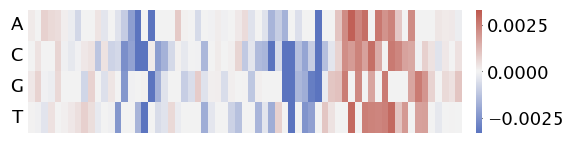

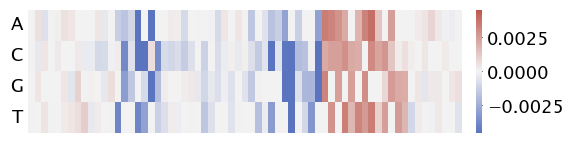

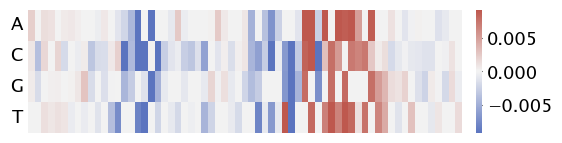

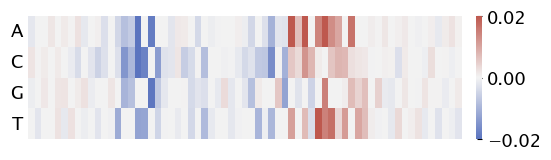

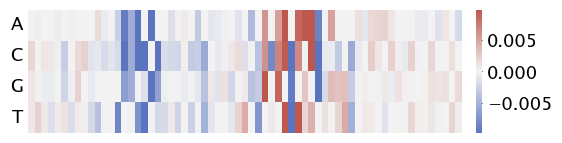

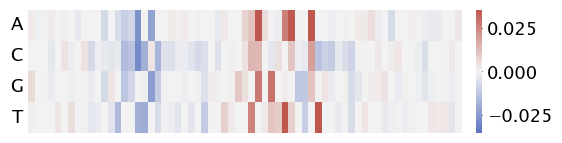

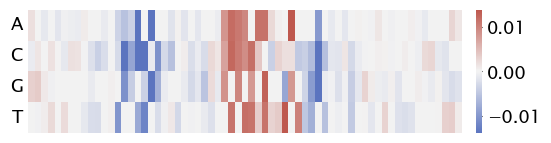

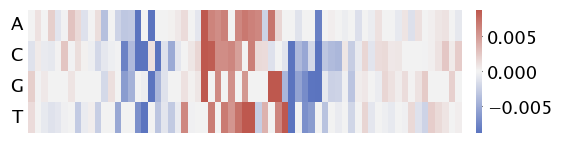

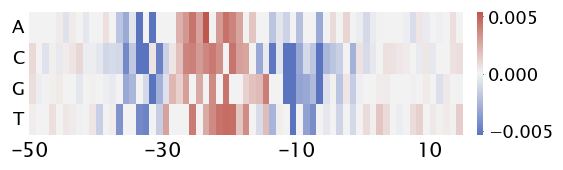

In [12]:
i = 0
for rep_start, rep_end, promoter, rnap_site, rep_site in res[2:11]:
	n_NS = len(genome)
	n_p = 4600
	n_r = 10
	ep_wt = -5
	er_wt = -15

	noxticks = False if i == len(res[2:11]) - 1 else True
	df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
							*[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

	plot_exshift_matrix(df, promoter, x_lims=(-50+115, 15 + 115),
					   	noxticks=noxticks,
						outfile=out_fdir + 'overlapping_exshift{}.pdf'.format(i))
	i += 1